# Read in the data

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = 10, 8


In [2]:

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

In [3]:
#!head -20 schools/ap_2010.csv
data['class_size'].sample(2)

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
16815,19,K,K409,East New York Family Academy,09-12,GEN ED,MATH,Integrated Algebra,-,63.0,3.0,21.0,17.0,23.0,STARS,NaN
5327,7,X,X029,P.S./M.S. 029 Melrose School,05,GEN ED,-,-,-,63.0,2.0,31.5,31.0,32.0,ATS,NaN


# Read in the surveys

In [4]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [5]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [6]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 
        'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], 
                                           errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [7]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [8]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [9]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [10]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [11]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

In [12]:
districts_ell = combined.groupby("school_dist").agg(np.mean)
districts_ell.reset_index(inplace=True)
districts_ell.sample(2)

,school_dist,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5,Total Cohort,CSD,...,grade_span_max,expgrade_span_max,zip,total_students,number_programs,priority08,priority09,priority10,lat,lon
4,05,427.159915,438.236674,419.666098,1285.062687,85.722527,115.725275,142.464286,143.677419,5.0,...,12.0,12.0,10030.142857,609.857143,1.142857,0.0,0.0,0.0,40.817077,-73.949251
30,31,457.500000,472.500000,452.500000,1382.500000,228.908654,355.111538,194.435000,450.787097,31.0,...,12.0,12.0,10307.100000,1847.500000,5.000000,0.0,0.0,0.0,40.595680,-74.125726


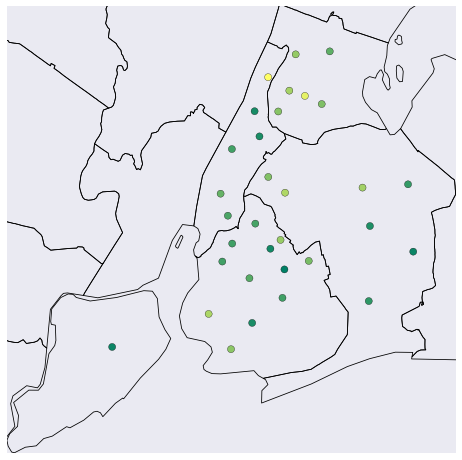

In [13]:
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawcounties(linewidth=0.8)

longitudes = districts_ell.lon.tolist()
latitudes = districts_ell.lat.tolist()

c = districts_ell["ell_percent"]
m.scatter(longitudes,latitudes,s=50,zorder=2,latlon=True,c = c, 
          cmap = "summer")
plt.show()

# Note:

Most of the high schools with low total enrollment and low SAT scores are actually schools with a high percentage of English language learners enrolled.

In [14]:
#Looking at Survey data
filter_list = survey_fields.copy()
#filter_list.remove('DBN')

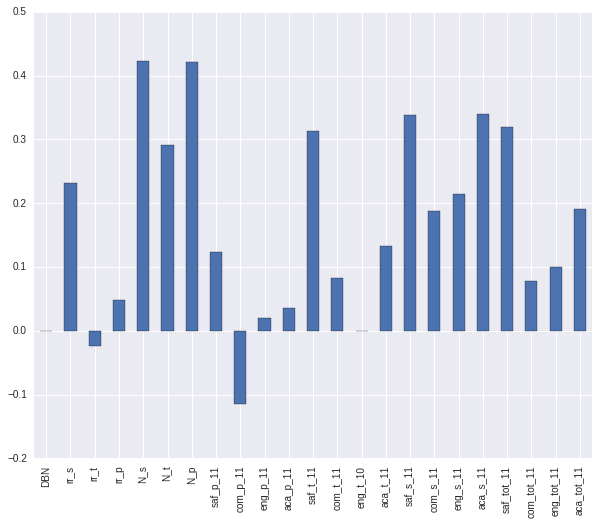

In [15]:
correlations[filter_list].plot.bar()
plt.show()

# Notes:

https://data.cityofnewyork.us/Education/NYC-School-Survey-2011/mnz3-dyi8

### Number of responses:

  - 'sat_scores' correlates positively with N_s, N_p and N_t.
  - N stands for number of responses.( _s = students, _t = teachers, _p = parents ).

### Academic Expectations:

  - aca_t(Academic expectation scores based on teacher responses) and aca_p(parents) responses does not correlate as a well aca_s(student).
  - Could it be that students have a better understanding of their academic expectations that teachers or parents?
  - Are student Academic expectations biased towards the 'sat_scores' academic metric. Students only care about SAT scores because high SAT scores increases probability of landing up in school of choice.
  - This could be another way of saying that academic expectations of teachers and parents might be applied over longer time spans, so SAT scores are merely a step in the right direction. 

### Safety:

  - Safety and Respect score(saf_tot_11) has a good correlation with 'sat_scores'. This may not be too surprising given that learning may not happen in the absence of safety.
  - Looking at individual schools with low safety rating might help shed light on the causal links.
      - Plot: Looking at scatterplot of saf_s_11 and sat_scores one can observe a general positive correlation.
      - There apepars to be a dense cluster of points located: sat_score<1400 and saf_c_11<7
      

### Communication:

  - com_p(Communication scores based on parent responses) correlates negatively. There is poor correlation with com_t but strongest with com_s.

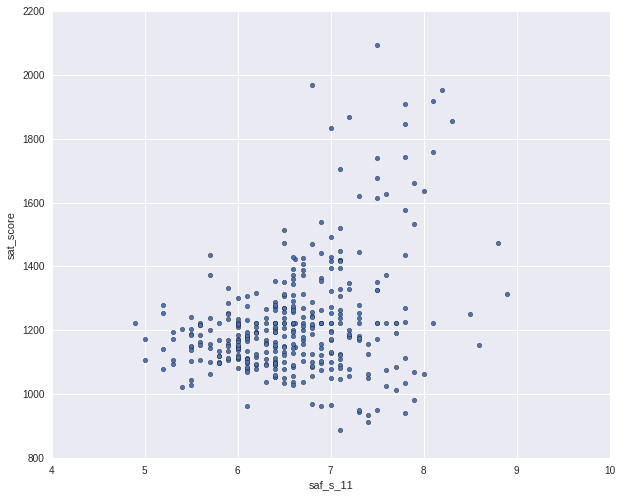

In [16]:
combined.plot.scatter(x='saf_s_11',y='sat_score')
plt.show()

In [17]:
districts_saf = combined.groupby(by='school_dist').agg(np.mean)
districts_saf.reset_index(inplace=True)

In [18]:
longitudes = districts_saf.lon.tolist()
latitudes = districts_saf.lat.tolist()

# Notes:

### Burrows of New York:
http://www.nycgo.com/boroughs-neighborhoods

### Safety:

- Schools in Brooklyn and some areas of Queens and The Bronx appear to have the lowest Safety and Respect ratings based on student responses. 

![Image of Burrows](http://www.mappi.net/img/newyork/nyc-arrondissements.jpg)




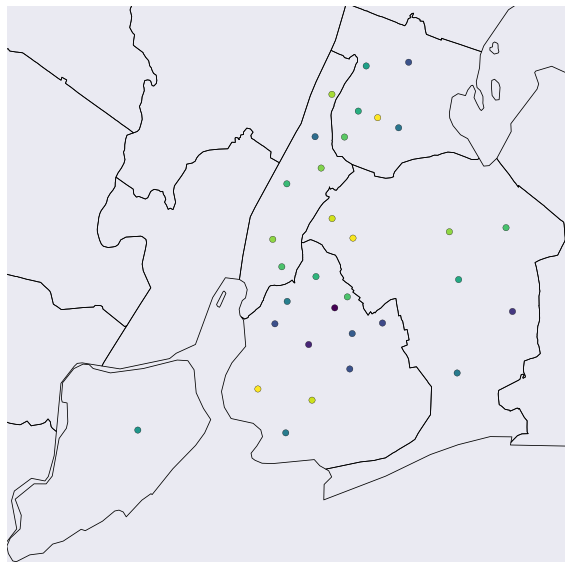

In [19]:
#!conda install -c conda-forge basemap-data-hires -y

plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)


#m.drawcoastlines(color='#6D5F47', linewidth=.4)
#m.drawrivers(color='#6D5F47', linewidth=.4)
#m.drawcoastlines()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color = 'coral')
m.drawrivers()
m.drawcounties(linewidth=0.8)


c = districts_saf['saf_s_11']

m.scatter(longitudes,latitudes,s=40,zorder=2,c=c,cmap='viridis',
          latlon=True)
#m.shadedrelief()
plt.show()

# Race and SAT scores:

- Racial background appears to have strong positive and negative correlation with SAT scores.
- Schools with higher percentage of students with White and Asian backgrounds are correlated with  higher SAT scores.
- Converse is true for schools with high percentage of Black or Hispanic students.
- Looking in socio-economic factors might unearth the basis for the racial bias.


In [20]:
race_per = ['white_per','asian_per','black_per','hispanic_per']
race_num = ['white_num','asian_num','black_num','hispanic_num']

white_per       0.620718
asian_per       0.570730
black_per      -0.284139
hispanic_per   -0.396985
Name: sat_score, dtype: float64


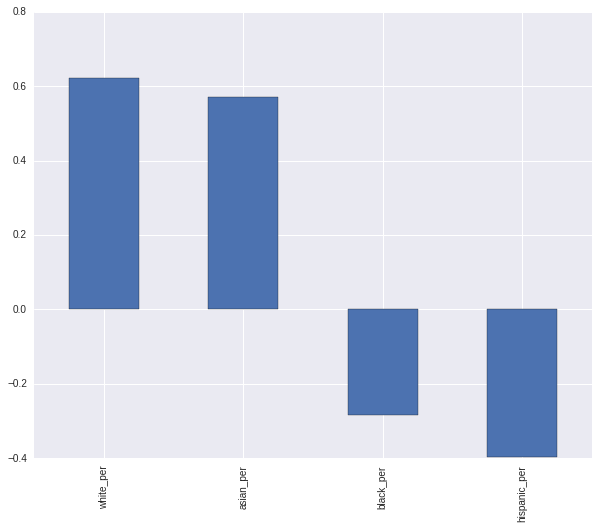

In [21]:
print(correlations[race_per])
correlations[race_per].plot.bar()

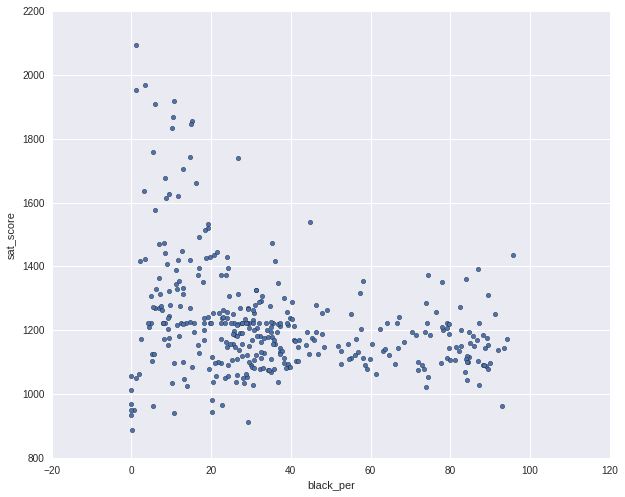

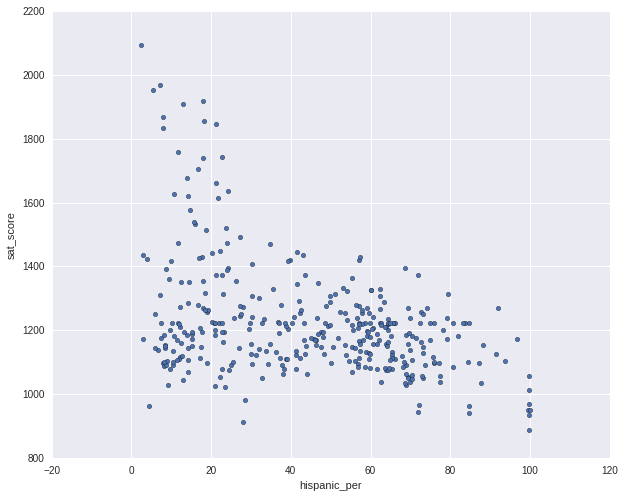

In [22]:
combined.plot.scatter(x='black_per',y='sat_score')
combined.plot.scatter(x='hispanic_per',y='sat_score')

# Gender and SAT scores:

- Modest negative-positive correlation between male-female genders. 
- It appears that schools with higher female percentage perform better on SAT test.



male_per     -0.112062
female_per    0.112108
Name: sat_score, dtype: float64


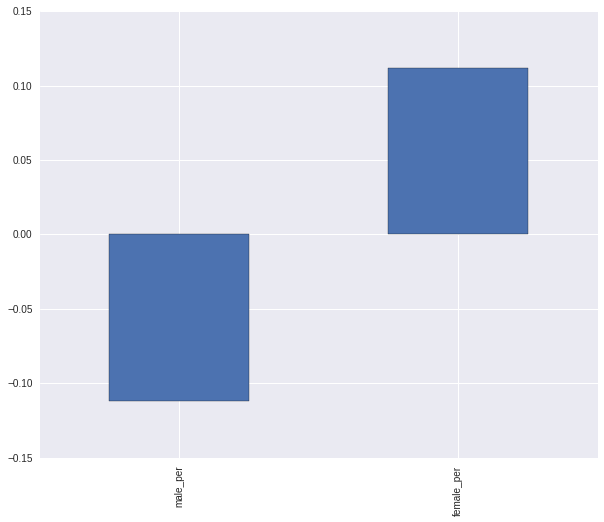

In [23]:
gender_per = ['male_per','female_per']

print(correlations[gender_per])
correlations[gender_per].plot.bar()

In [24]:
combined.sample(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
29,02M420,HIGH SCHOOL FOR HEALTH PROFESSIONS AND HUMAN S...,336,429.0,449.0,428.0,1306.0,HEALTH PROF & HUMAN SVCS,204.0,248.0,...,0,0,0,0,0,0,"345 East 15Th Street\nNew York, NY 10003\n(40....",40.732485,-73.983053,02
153,10X546,BRONX THEATRE HIGH SCHOOL,68,348.0,362.0,354.0,1064.0,Bronx Theatre High School,34.0,34.0,...,0,0,0,0,0,0,"99 Terrace View Avenue\nBronx, NY 10463\n(40.8...",40.877049,-73.912337,10


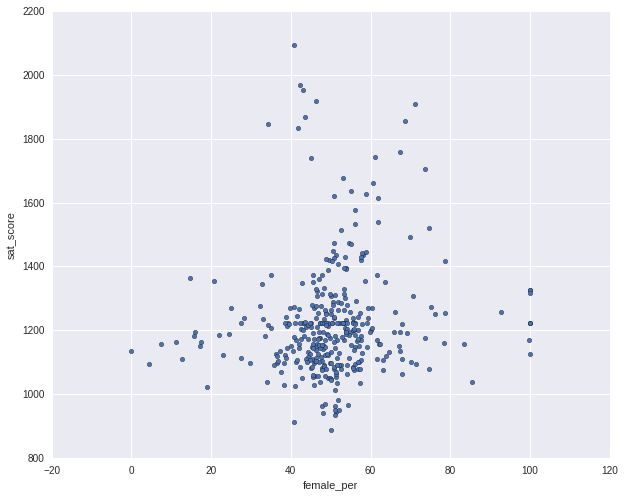

In [25]:
combined.plot.scatter(x='female_per',y='sat_score')

In [26]:
highperforming_schools = combined[(combined['female_per']>60) & (combined['sat_score']>1600)]

longitudes = highperforming_schools.lon.tolist()
latitudes = highperforming_schools.lat.tolist()
highperforming_schools

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
27,02M418,MILLENNIUM HIGH SCHOOL,144,528.0,553.0,533.0,1614.0,Millennium High School,86.000000,95.000000,...,0,0,0,0,0,0,"75 Broad Street\nNew York, NY 10004\n(40.70492...",40.704920,-74.011514,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
287,24Q299,BARD HIGH SCHOOL EARLY COLLEGE II,155,545.0,568.0,550.0,1663.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"30-20 Thomson Avenue\nLong Island City, NY 111...",40.745094,-73.936814,24
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


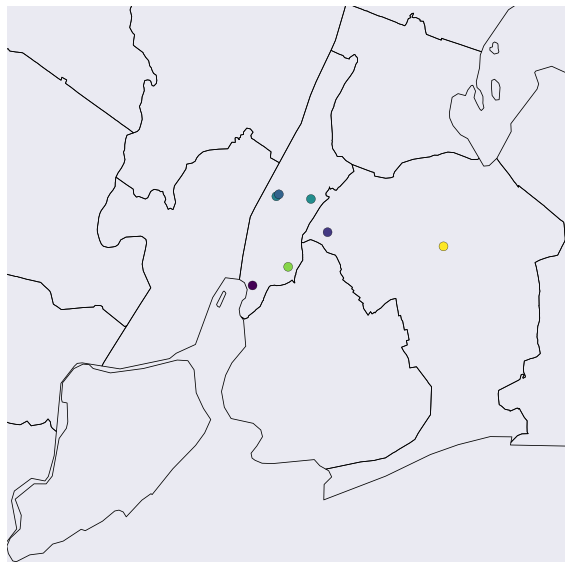

In [27]:
plt.figure(figsize=(10,10))
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)


#m.drawcoastlines(color='#6D5F47', linewidth=.4)
#m.drawrivers(color='#6D5F47', linewidth=.4)
#m.drawcoastlines()
#m.drawmapboundary(fill_color='aqua')
#m.fillcontinents(color = 'coral')
m.drawrivers()
m.drawcounties(linewidth=0.8)


c = highperforming_schools['sat_score']

m.scatter(longitudes,latitudes,s=80,zorder=2,c=c,cmap='viridis',
          latlon=True)
#m.shadedrelief()
plt.show()

# Notes:

- The high performing schools are located in Manhattan, Flushing, Queens and Long island.
- The schools are either privately owned or are selective enrollment type schools.
- A quick look at demographic data on wikipedia indicates a high percentage of White and Asians americans in these areas. 

References: 
1. https://en.wikipedia.org/wiki/Flushing,_Queens
2. https://en.wikipedia.org/wiki/Manhattan#Demographics
3. https://en.wikipedia.org/wiki/Long_Island#Demographics

# AP Scores vs SAT scores

In [28]:
data['ap_2010'].sample(2)

,DBN,SchoolName,AP Test Takers,Total Exams Taken,Number of Exams with scores 3 4 or 5
128,11X418,BRONX HS FOR THE VISUAL ARTS,26.0,41.0,9.0
253,31R605,STATEN ISLAND TECHNICAL HS,528.0,905.0,809.0


,sat_score,ap_per
sat_score,1.000000,0.057171
ap_per,0.057171,1.000000


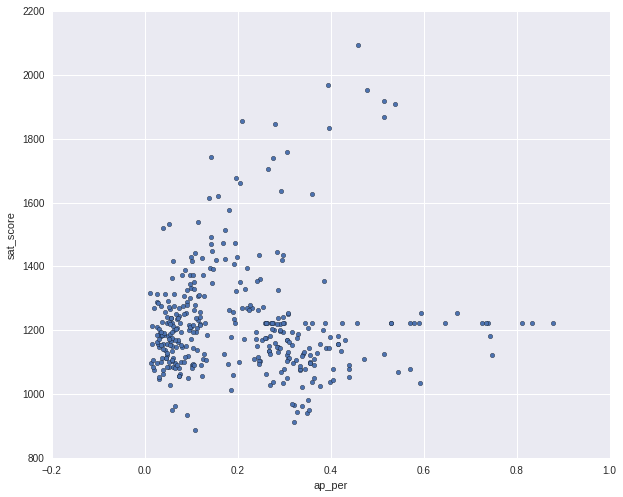

In [42]:
#Computing the percentage of AP test takers
combined['ap_per'] = combined['AP Test Takers ']/ combined['total_enrollment']
combined.plot.scatter(x='ap_per',y='sat_score')
combined[['sat_score','ap_per']].corr()

In [43]:
#Converting the Num of SAT test takers to numeric array
combined['Num_SAT_test_takers'] = pd.to_numeric(combined['Num of SAT Test Takers'],errors='coerce')

#Computing the percentage of enrolled students who take the SAT
combined['SAT_per'] = combined['Num_SAT_test_takers'] / combined['total_enrollment']

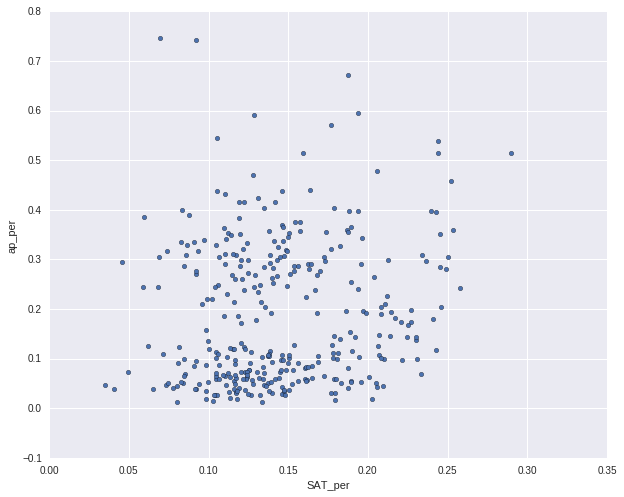

,SAT_per,ap_per
SAT_per,1.000000,0.143934
ap_per,0.143934,1.000000


In [44]:
SATvsAP = combined[['SAT_per','ap_per']].dropna()
SATvsAP.plot.scatter(x='SAT_per',y='ap_per')
plt.show()
SATvsAP.corr()

# Notes:

- There doesn't appear to a strong correlation between AP scores and SAT scores. 
- There correlation between the percentage of students taking the AP test and SAT test is stronger(~14.5%). 
- So schools which have higher percentage of SAT test takers may also have higher percentage AP test takers. 

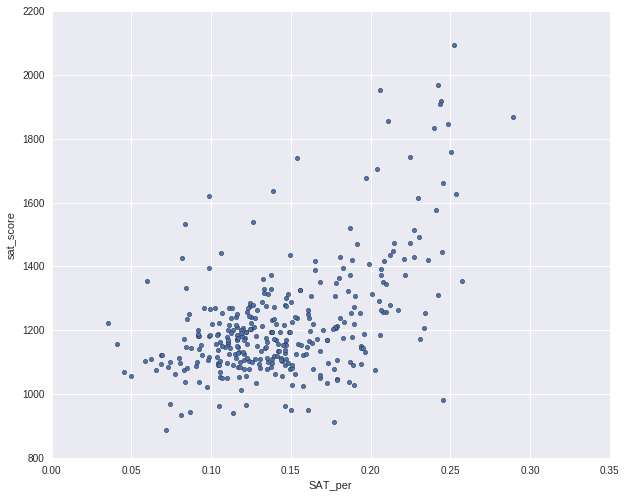

In [39]:
combined.plot.scatter(x='SAT_per',y='sat_score')